In [1]:
#imports:

#Numpy
import numpy as  np
#Fitting data to theoretical model 
import scipy.optimize as scop
import scipy.special as sc
from astropy.modeling import models, fitting
#STL image creator
from stl import mesh
#Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Fits opening
from astropy.io import fits
#Ellips fitting
from photutils.isophote import EllipseGeometry,Ellipse
from photutils import EllipticalAperture

#resizing of images
import cv2

In [2]:
#Plummer model (not used anymore)
def Plummer(x,y,xoff,yoff,a):
    return a/(a+(x-xoff)**2+(y-yoff)**2)**(5/2)

#2D Sersic model (n=4: De Vaucouleurs's ; n =1: exponential)
def Sersic2D(x,y,xoff,yoff,n,b,rscale,e,theta):
    xp = (x-xoff)*np.cos(-theta) + (y-yoff)*np.sin(-theta)
    yp = (y-yoff)*np.cos(-theta) - (x-xoff)*np.sin(-theta)
    return np.exp(-1*b*(np.sqrt((xp/(1-e))**2+yp**2)/rscale)**(1/n))

#1D Sersic model (n=4: De Vaucouleurs's ; n =1: exponential) 
def Sersic(r,n,b,rscale):
    return np.exp(-1*b*(r/rscale)**(1/n))

#2D King model
def King2D(x,y,xoff,yoff,rc,rt,e,theta):
    xp = (x-xoff)*np.cos(-theta) + (y-yoff)*np.sin(-theta)
    yp = (y-yoff)*np.cos(-theta) - (x-xoff)*np.sin(-theta)
    r = np.sqrt((xp/(1-e))**2+yp**2)
    return rc**2*(1/np.sqrt(r**2+rc**2)-1/np.sqrt(rt**2+rc**2))**2

#1D King model
def King1D(r,rc,rt,e,theta):
    return rc**2*(1/np.sqrt(r**2+rc**2)-1/np.sqrt(rt**2+rc**2))**2

#Fitter function of the data to the theoretical model
#def optimizable(X, args):
#    n,b = X
#    dataNp,max_cols,max_rows,el,posa,center,r_scale = args
#    dNp = 10**dataNp[center[0][0]:center[0][1],center[1][0]:center[1][1]]  
#    modelNp = np.zeros((center[0][1]-center[0][0],center[1][1]-center[1][0]))
#    x_off = max_cols/2
#    y_off = max_rows/2
#    for x in range(0, center[0][1]-center[0][0]):
#        for y in range(0, center[1][1]-center[1][0]):
#            modelNp[x][y] = Sersic2D(x,y,x_off,y_off,n,b,r_scale,el,posa)
#    mNp = 10**modelNp
#    return abs(dNp/dNp.max() - mNp/mNp.max()).sum()

#Fitter function of the b variable to the expected value
def b_optimizable(X, args):
    b = X
    n = args
    return abs(1 - 2*sc.gammainc(2*n,b))

#Function that creates triangles of the model that we want to print from the (x,y,z) positions array that we feed in.
#Can show the scaling radius as well if parameters are provided
def facemaker(Nparr,max_cols,max_rows,x_off = None,y_off = None,r_scale = None,e = None,theta = None):
    vertices=np.zeros((max_rows,max_cols,3))    
    
    if r_scale != None and e != None and theta != None:
        ellipzarr = []
        for x in range(0, max_cols):
            for y in range(0, max_rows):
                xp = (x-x_off)*np.cos(-theta) + (y-y_off)*np.sin(-theta)
                yp = (y-y_off)*np.cos(-theta) - (x-x_off)*np.sin(-theta)
                if r_scale + 1 >= np.sqrt((xp/(1-e))**2+yp**2) >= r_scale-1:
                    ellipzarr.append(Nparr[x][y])
                    
        if len(ellipzarr) != 0:
            zmax = max(ellipzarr)
        else:
            zmax = 0
    
    for x in range(0, max_cols):
        for y in range(0, max_rows):
            z = Nparr[x][y]
            
            if r_scale != None and e != None and theta != None:                
                xp = (x-x_off)*np.cos(-theta) + (y-y_off)*np.sin(-theta)
                yp = (y-y_off)*np.cos(-theta) - (x-x_off)*np.sin(-theta)
                
                if r_scale + 1.5 >= np.sqrt((xp/(1-e))**2+yp**2) >= r_scale-1.5:
                    z = zmax
                    vertices[y][x] = (x,y,z)#(x+1.5*abs(x-x_off)/(x-x_off),y+1.5*abs(y-y_off)/(y-y_off),z+0.5)
                else:
                    vertices[y][x]=(x, y, z)
                    
            else:
                vertices[y][x]=(x, y, z)

    faces=[]
    
    #faces for the input array
    for x in range(0, max_cols - 1):
        for y in range(0, max_rows - 1):
            # create face 1
            vertice1 = vertices[y][x]
            vertice2 = vertices[y+1][x]
            vertice3 = vertices[y+1][x+1]
            face1 = np.array([vertice1,vertice2,vertice3])

            # create face 2 
            vertice1 = vertices[y][x]
            vertice2 = vertices[y][x+1]
            vertice3 = vertices[y+1][x+1]

            face2 = np.array([vertice1,vertice2,vertice3])

            faces.append(face1)
            faces.append(face2)
            
            

    #faces for the bottom layer and edges
    for i in range(0,4):
        for j in range(0,[max_cols,max_rows][i%2]-1):
            y1,x1 = [[[0,-1][i//2],j],[j,[0,-1][i//2]]][i%2]
            y2,x2 = [[[0,-1][i//2],j+1],[j+1,[0,-1][i//2]]][i%2]
            # create face 1 & 2
            vertice1 = vertices[y1][x1]
            vertice2 = vertices[y2][x2]
            vertice3 = (vertice1[0],vertice1[1],0)
            vertice4 = (vertice2[0],vertice2[1],0)

            face1 = np.array([vertice1,vertice3,vertice4])
            face2 = np.array([vertice1,vertice2,vertice4])

            faces.append(face1)
            faces.append(face2)


    faces.append(np.array([(0,0,0),(0,max_rows-1,0),(max_cols-1,max_rows-1,0)]))
    faces.append(np.array([(0,0,0),(max_cols-1,0,0),(max_cols-1,max_rows-1,0)]))
    return faces

def facemaker_v2(Nparr,x_len,y_len):
    ncols,nrows = Nparr.shape
    vertices=np.zeros((nrows,ncols,3))    
    
    
    for x in range(0, ncols):
        for y in range(0, nrows):
            z = Nparr[x][y]
            
            vertices[y][x]=(x/(ncols-1)*x_len, y/(nrows-1)*y_len, z)

    faces=[]
    
    #faces for the input array
    for x in range(0, ncols - 1):
        for y in range(0, nrows - 1):
            # create face 1
            vertice1 = vertices[y][x]
            vertice2 = vertices[y+1][x]
            vertice3 = vertices[y+1][x+1]
            face1 = np.array([vertice1,vertice2,vertice3])

            # create face 2 
            vertice1 = vertices[y][x]
            vertice2 = vertices[y][x+1]
            vertice3 = vertices[y+1][x+1]

            face2 = np.array([vertice1,vertice2,vertice3])

            faces.append(face1)
            faces.append(face2)
            
            

    #faces for the bottom layer and edges
    for i in range(0,4):
        for j in range(0,[ncols,nrows][i%2]-1):
            y1,x1 = [[[0,-1][i//2],j],[j,[0,-1][i//2]]][i%2]
            y2,x2 = [[[0,-1][i//2],j+1],[j+1,[0,-1][i//2]]][i%2]
            # create face 1 & 2
            vertice1 = vertices[y1][x1]
            vertice2 = vertices[y2][x2]
            vertice3 = (vertice1[0],vertice1[1],0)
            vertice4 = (vertice2[0],vertice2[1],0)

            face1 = np.array([vertice1,vertice3,vertice4])
            face2 = np.array([vertice1,vertice2,vertice4])

            faces.append(face1)
            faces.append(face2)


    faces.append(np.array([(0,0,0),(0,y_len,0),(x_len,y_len,0)]))
    faces.append(np.array([(0,0,0),(x_len,0,0),(x_len,y_len,0)]))
    return faces

def ellipsemaker(max_cols,max_rows,x_off,y_off,r, el, theta,h,width):
    R = r +width
    N = 50
    vertices=np.zeros((2*N,3))
    faces = []
    for i,xp in enumerate(np.linspace((-1*R)*(1-el),R*(1-el),N)):
        yp_plus = np.sqrt(np.abs(R**2-(xp/(1-el))**2))
        yp_minus = -1*yp_plus
        x_plus = xp*np.cos(-theta) - yp_plus*np.sin(-theta) + x_off
        y_plus = yp_plus*np.cos(-theta) + xp*np.sin(-theta) + y_off
        x_minus = xp*np.cos(-theta) - yp_minus*np.sin(-theta) + x_off
        y_minus = yp_minus*np.cos(-theta) + xp*np.sin(-theta) + y_off
        vertices[i] = (x_plus,y_plus,h)
        vertices[2*N-1-i] = (x_minus,y_minus,h)
    
    for j in range(2*N):
        vertice1 = vertices[j]
        if 0 <= vertice1[0] <= max_cols and 0 <= vertice1[1] <= max_rows:
                vertice2 = vertices[(j+1)%(2*N)]
                if 0 <= vertice2[0] <= max_cols and 0 <= vertice2[1] <= max_rows:
                    vertice3 = (x_off,y_off,h)
                    face1 = np.array([vertice1,vertice2,vertice3])

                    vertice4 = (vertice1[0],vertice1[1],0)
                    vertice5 = (vertice2[0],vertice2[1],0)
                    face2 = np.array([vertice1,vertice4,vertice5])

                    face3 = np.array([vertice1,vertice2,vertice5])
                    
                    vertice6 = (x_off,y_off,0)
                    face4 = ([vertice4,vertice5,vertice6])
                    
                    
                    faces.append(face1)
                    faces.append(face2)
                    faces.append(face3)
                    faces.append(face4)
    
    return faces

0.07792561310788412 1.3503935251885242
17.810849971819202 1597.1540474147346
Outer sersic:  0.07116918314318091 1.903179861196047
Outer sersic:  88.79496272866157 1271.8956739525702
amplitude:  2250.937767909804
Outer sersic:  1.6055029862770975 2.884531141058416 52.86804755389328 40.83280086076187 37.7831681383964


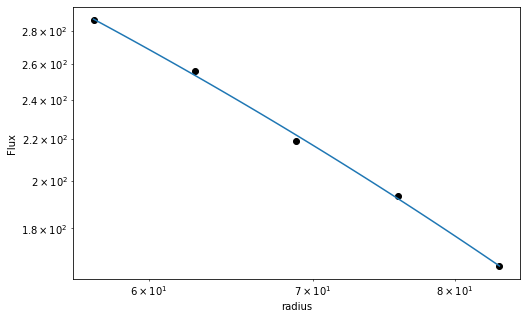

0.06316646873983675 0.838081192187851
10.87805189239354 1013.737458046195
amplitude:  3269.9616801750844
1.5350981880820451 2.7440697295630123 Parameter('r_eff', value=32.74408414448886) 40.60279513862268 38.042600396878726


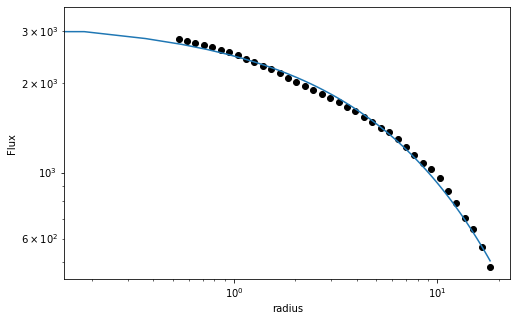

9.853007079374128 113.78340445920995
0.20058614949328982
number of faces: 42976
r_scale = Parameter('r_eff', value=32.74408414448886), n_inner = 1.5350981880820451 and n_outer = 1.6055029862770975


In [16]:
#Code for 3D model of m87 with theoretical model attached

#Loading the file
directory = 'm_87_(elliptical)'
F = fits.open(directory+'/200416_Li_.00000043.M_87.FIT')

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[953:1103,1399:1539]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()

#Fitting without the outer Sersic
begin = 0
end = len(isolist1)-11

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

n_no_edge = t.n[0]

r_scale_no_edge = t.r_eff[0]

b_no_edge = scop.minimize(b_optimizable, x0=2, args = n_no_edge ,bounds = [(0,None)], tol=1e-8).x[0]

#Outer sersic fit:
begin_edge = len(isolist1)-5

end_edge = len(isolist1)-0

isolist_edge= isolist1[begin_edge: end_edge]

el_edge = isolist_edge.eps.mean()# ellipticity (not eccentricity)
posa_edge = isolist_edge.pa.mean() #position angle

print("Outer sersic: ",el_edge,posa_edge)

spec_edge = isolist_edge.intens #intensity gradient
rs_edge = isolist_edge.sma #semi major axis
tfluxlist_edge = isolist_edge.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist_edge[i] < tfluxlist_edge[-1]/2:
    i += 1

r_scale1_edge = (tfluxlist_edge[i]-tfluxlist_edge[-1]/2)/(tfluxlist_edge[i]-tfluxlist_edge[i-1])*(rs_edge[i]-rs_edge[i-1])+rs_edge[i-1]
Amp_edge = (spec_edge[i-1]-spec_edge[i])*(r_scale1_edge-rs_edge[i-1])+ spec_edge[i-1]

print("Outer sersic: ",r_scale1_edge,Amp_edge)

#Fitting the physical model to the data
init_edge = models.Sersic1D(amplitude = Amp_edge, r_eff = r_scale1_edge,n=4)

fit_edge = fitting.LevMarLSQFitter()
t_edge = fit_edge(init_edge, rs_edge, spec_edge)

n_edge = t_edge.n[0]

r_scale_edge = t_edge.r_eff[0]*resfrac
r_scale_edge_2 = t_edge.r_eff[0]

#Finding (analytically) what the parameter b should be
b_edge = scop.minimize(b_optimizable, x0=2, args = n_edge ,bounds = [(0,None)], tol=1e-8).x[0]

x_off_edge = isolist_edge.y0.mean()*resfrac

y_off_edge = isolist_edge.x0.mean()*max_rows/nrows

Amp_edge = t_edge.amplitude[0]*np.exp(b_edge)

print("amplitude: ",Amp_edge)

print("Outer sersic: ",n_edge,b_edge,r_scale_edge,x_off_edge,y_off_edge)

#Plotting how well we fitted
X_edge = np.linspace(min(rs_edge),max(rs_edge),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs_edge, spec_edge, 'ko')
plt.plot(X_edge, t_edge(X_edge))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()


#Creating edge Sersic model
isolist= isolist1[0: begin_edge]

x_off = isolist.y0[10]*resfrac
x_off_2 = isolist.y0[10]

y_off = isolist.x0[10]*max_rows/nrows
y_off_2 = isolist.x0[10]

edge_modelarr = np.zeros((ncols,nrows))
#Only model on the outside
for x in range(0, ncols):
    for y in range(0, nrows):
        edge_modelarr[x][y] = Amp_edge*Sersic2D(x,y,x_off_2,y_off_2,n_edge,b_edge,r_scale_edge_2,el_edge,posa_edge)*(1-1/(1+np.sqrt((x-x_off_2)**2+(y-y_off_2)**2)**1.5))/(1-1/(1+np.sqrt((ncols-x_off_2-1)**2+(nrows-y_off_2-1)**2)**1.5))


geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp-edge_modelarr, geometry) 
isolist1 = ellipse.fit_image()

#Inner sersic fit:
begin = 0
end= len(isolist1)-13

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

n = t.n[0]

r_scale_2 = t.r_eff

#Finding (analytically) what the parameter b should be
b = scop.minimize(b_optimizable, x0=2, args = n ,bounds = [(0,None)], tol=1e-8).x[0]

x_off = isolist.y0[15]*resfrac
x_off_2 = isolist.y0[15]

y_off = isolist.x0[15]*max_rows/nrows
y_off_2 = isolist.x0[15]

Amp_in = t.amplitude[0]*np.exp(b)
print("amplitude: ",Amp_in)

print(n,b,r_scale_2,x_off,y_off)


#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()


#Making the physical model using fitted parameters
modelarr_in_2 = np.zeros((ncols,nrows))
modelarr_edge_2 = np.zeros((ncols,nrows))
for x in range(0, ncols):
    for y in range(0, nrows):
        modelarr_in_2[x][y] = Amp_in*Sersic2D(x,y,x_off_2,y_off_2,n,b,r_scale_2,el,posa)
        modelarr_edge_2[x][y] =Amp_edge*Sersic2D(x,y,x_off_2,y_off_2,n_edge,b_edge,r_scale_edge_2,el,posa)*(1-1/(1+np.sqrt((x-x_off_2)**2+(y-y_off_2)**2)**1.5))/(1-1/(1+np.sqrt((ncols-x_off_2-1)**2+(nrows-y_off_2-1)**2)**1.5))      

print(modelarr_in_2[0][0],modelarr_edge_2[0][0])
modelarr_2 = modelarr_edge_2+modelarr_in_2

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m_2=modelarr_2.min()
modelarr_2 -= min_pix_m_2
max_pix_m_2=modelarr_2.max()

min_pix_i_2=imageNp.min()
imageNp -= min_pix_i_2
max_pix_i_2=imageNp.max()

scaledmodelarr_2 = (modelarr_2 * max_height) / max_pix_m_2 + 1.6   #lowest vertex will be at 1.6 mm
scaledimageNp = (imageNp * max_height) / max_pix_i_2 + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model           
compNp_2 = np.zeros((ncols,nrows))
for x in range(0,ncols):
    for y in range(0,nrows):
        if x <= ncols/2:
            compNp_2[x][y] = scaledmodelarr_2[x][y]
        else:
            compNp_2[x][y] = scaledimageNp[x][y]

#Creating the list of faces out of the array                        
H1 = Sersic(r_scale_no_edge,n_no_edge,b_no_edge,r_scale_no_edge)
height = H1*max_height
print(H1)

faces_2 = facemaker_v2(compNp_2,max_cols,max_rows)
elfaces_2 = ellipsemaker(max_cols,max_rows,x_off_2*resfrac,y_off_2*max_rows/nrows,r_scale_2*resfrac, el, posa,height,6)

print(f"number of faces: {len(faces_2)+len(elfaces_2)}")
facesNp_2 =np.append(faces_2,elfaces_2,axis = 0) 

surface_2 = mesh.Mesh(np.zeros(facesNp_2.shape[0], dtype=mesh.Mesh.dtype))

# Create the mesh
for i in range(len(faces_2)+len(elfaces_2)):
    for j in range(3):
        surface_2.vectors[i][j] = facesNp_2[i][j]
        
# Write the mesh to a file so we can print it
surface_2.save('Sersic_model_+_elliptical_M_87_v2.stl')

print("r_scale = {}, n_inner = {} and n_outer = {}".format(r_scale_2,n,n_edge))

F.close()

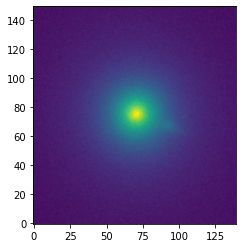

(array([75], dtype=int64), array([72], dtype=int64))
75.0 70.0


In [4]:
ncols,nrows = imageNp.shape
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')
  
plt.show()

inds = np.where(imageNp==imageNp.max())
print(inds)
print(ncols/2,nrows/2)

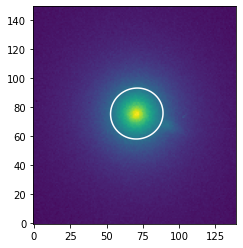

In [5]:
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')

j =(len(isolist)-1)
iso = isolist[j]
x, y, = iso.sampled_coordinates()
ax.plot(x, y, color='white')
plt.show()

In [ ]:
'''
#Code for 3D model of m60 with theoretical model attached

#Loading the file
directory = 'm_60_(elliptical)'
F = fits.open(directory+'/200416_Li_.00000037.M_60.FLAT.FIT')

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[986:1086,1459:1559]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#reducing resolution of the image to the above parameters
resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()

begin = 0
end = len(isolist1)-7

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()

n = t.n[0]

r_scale_2 = t.r_eff[0]

#Finding (analytically) what the parameter b should be
b = scop.minimize(b_optimizable, x0=2, args = n ,bounds = [(0,None)], tol=1e-8).x[0]

x_off_2 = isolist.y0[10:-1].mean() +1.4

y_off_2 = isolist.x0[10:-1].mean()

print(n,b,r_scale_2,x_off_2,y_off_2)

#Making the physical model using fitted parameters
modelarr_2 = np.zeros((ncols,nrows))

for x in range(0,ncols):
    for y in range(0, nrows):
        modelarr_2[x][y] = Sersic2D(x,y,x_off_2,y_off_2,n,b,r_scale_2,el,posa)

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m_2=modelarr_2.min()
modelarr_2 -= min_pix_m_2
max_pix_m_2=modelarr_2.max()

min_pix_i_2=imageNp.min()
imageNp -= min_pix_i_2
max_pix_i_2=imageNp.max()

scaledmodelarr_2 = (modelarr_2 * max_height) / max_pix_m_2 + 1.6   #lowest vertex will be at 1.6 mm
scaledimageNp = (imageNp * max_height) / max_pix_i_2 + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model         
compNp_2 = np.zeros((ncols,nrows))
for x in range(0,ncols):
    for y in range(0,nrows):
        if x <= ncols/2:
            compNp_2[x][y] = scaledmodelarr_2[x][y]
        else:
            compNp_2[x][y] = scaledimageNp[x][y]

#Creating the list of faces out of the array                        
faces_2 = facemaker_v2(compNp_2,max_cols,max_rows)
elfaces_2 = ellipsemaker(max_cols,max_rows,x_off_2*resfrac,y_off_2*max_rows/nrows,r_scale_2*resfrac, el, posa,Sersic(r_scale_2*resfrac,n,b,r_scale_2*resfrac)*max_height+1.6,2)
#elfaces = []

print(f"number of faces 2: {len(faces_2)+len(elfaces_2)}") 
facesNp_2 = np.append(faces_2,elfaces_2,axis = 0) 
#facesNp = np.array(faces)

# Create the mesh       
surface_2 = mesh.Mesh(np.zeros(facesNp_2.shape[0], dtype=mesh.Mesh.dtype))
for i in range(len(faces_2)+len(elfaces_2)):
    for j in range(3):
        surface_2.vectors[i][j] = facesNp_2[i][j]
        
# Write the mesh to a file so we can print it
surface_2.save('Sersic_model_+_elliptical_M_60_v2.stl')

F.close()

#x_off, edge can't be fit for some reason.
'''

0.1205484733960659 1.9412497992641582
15.032915166059087 1829.7500390684163
Outer sersic:  0.16659072241611145 2.9427269694407165
Outer sersic:  80.43650925220284 2205.424063614748
amplitude:  8939.415404258982
Outer sersic:  2.0791977855532235 3.8302341472456276 58.11780352827049 39.18273892887133 41.31719139004409


C:\Users\jaspe\anaconda3\lib\site-packages\astropy\modeling\functional_models.py:709: RuntimeWarning: invalid value encountered in power
  -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)))


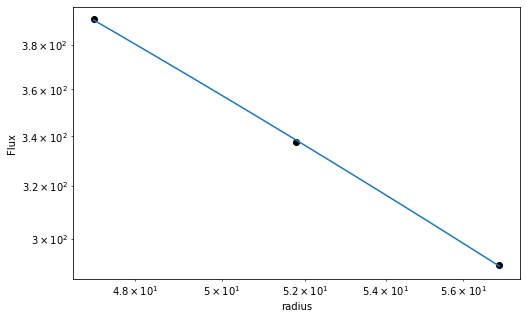

0.1244985945839456 0.9772554276578452
8.45461150013145 1282.182900718793
amplitude:  4697.373896159321
1.6770307481036304 3.027265451333016 Parameter('r_eff', value=26.156534650989816) 38.999933639731566 41.24148893224671


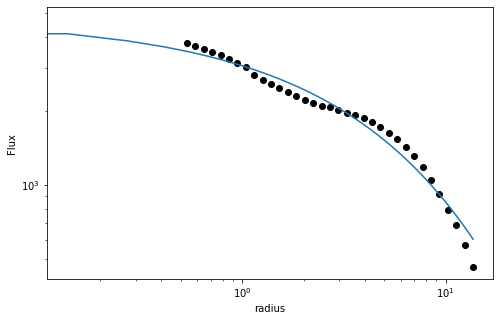

19.749288075214473 199.96415206081724
0.23254127666193555
number of faces: 20796
r_scale = Parameter('r_eff', value=26.156534650989816), n_inner = 1.6770307481036304 and n_outer = 2.0791977855532235


In [11]:
#Code for 3D model of m60 with theoretical model attached

#Loading the file
directory = 'm_60_(elliptical)'
F = fits.open(directory+'/200416_Li_.00000037.M_60.FLAT.FIT')

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[986:1086,1459:1559]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()

#Fitting without the outer Sersic
begin = 0
end = len(isolist1)-7

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

n_no_edge = t.n[0]

r_scale_no_edge = t.r_eff[0]

b_no_edge = scop.minimize(b_optimizable, x0=2, args = n_no_edge ,bounds = [(0,None)], tol=1e-8).x[0]

#Outer sersic fit:
begin_edge = len(isolist1)-4

end_edge = len(isolist1)-1

isolist_edge= isolist1[begin_edge: end_edge]

el_edge = isolist_edge.eps.mean()# ellipticity (not eccentricity)
posa_edge = isolist_edge.pa.mean() #position angle

print("Outer sersic: ",el_edge,posa_edge)

spec_edge = isolist_edge.intens #intensity gradient
rs_edge = isolist_edge.sma #semi major axis
tfluxlist_edge = isolist_edge.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist_edge[i] < tfluxlist_edge[-1]/2:
    i += 1

r_scale1_edge = (tfluxlist_edge[i]-tfluxlist_edge[-1]/2)/(tfluxlist_edge[i]-tfluxlist_edge[i-1])*(rs_edge[i]-rs_edge[i-1])+rs_edge[i-1]
Amp_edge = (spec_edge[i-1]-spec_edge[i])*(r_scale1_edge-rs_edge[i-1])+ spec_edge[i-1]

print("Outer sersic: ",r_scale1_edge,Amp_edge)

#Fitting the physical model to the data
init_edge = models.Sersic1D(amplitude = Amp_edge, r_eff = r_scale1_edge,n=4)

fit_edge = fitting.LevMarLSQFitter()
t_edge = fit_edge(init_edge, rs_edge, spec_edge)

n_edge = t_edge.n[0]

r_scale_edge = t_edge.r_eff[0]*resfrac
r_scale_edge_2 = t_edge.r_eff[0]

#Finding (analytically) what the parameter b should be
b_edge = scop.minimize(b_optimizable, x0=2, args = n_edge ,bounds = [(0,None)], tol=1e-8).x[0]

x_off_edge = isolist_edge.y0.mean()*resfrac

y_off_edge = isolist_edge.x0.mean()*max_rows/nrows

Amp_edge = t_edge.amplitude[0]*np.exp(b_edge)

print("amplitude: ",Amp_edge)

print("Outer sersic: ",n_edge,b_edge,r_scale_edge,x_off_edge,y_off_edge)

#Plotting how well we fitted
X_edge = np.linspace(min(rs_edge),max(rs_edge),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs_edge, spec_edge, 'ko')
plt.plot(X_edge, t_edge(X_edge))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()


#Creating edge Sersic model
isolist= isolist1[0: begin_edge]

x_off = isolist.y0[10]*resfrac
x_off_2 = isolist.y0[10]

y_off = isolist.x0[10]*max_rows/nrows
y_off_2 = isolist.x0[10]

edge_modelarr = np.zeros((ncols,nrows))
#Only model on the outside
for x in range(0, ncols):
    for y in range(0, nrows):
        edge_modelarr[x][y] = Amp_edge*Sersic2D(x,y,x_off_2,y_off_2,n_edge,b_edge,r_scale_edge_2,el_edge,posa_edge)*(1-1/(1+np.sqrt((x-x_off_2)**2+(y-y_off_2)**2)**1.5))/(1-1/(1+np.sqrt((ncols-x_off_2-1)**2+(nrows-y_off_2-1)**2)**1.5))


geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp-edge_modelarr, geometry) 
isolist1 = ellipse.fit_image()

#Inner sersic fit:
begin = 0
end= len(isolist1)-13

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

n = t.n[0]

r_scale_2 = t.r_eff

#Finding (analytically) what the parameter b should be
b = scop.minimize(b_optimizable, x0=2, args = n ,bounds = [(0,None)], tol=1e-8).x[0]

x_off = (isolist.y0[15])*resfrac
x_off_2 = isolist.y0[15]

y_off = isolist.x0[15]*max_rows/nrows
y_off_2 = isolist.x0[15]

Amp_in = t.amplitude[0]*np.exp(b)
print("amplitude: ",Amp_in)

print(n,b,r_scale_2,x_off,y_off)


#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()


#Making the physical model using fitted parameters
modelarr_in_2 = np.zeros((ncols,nrows))
modelarr_edge_2 = np.zeros((ncols,nrows))
for x in range(0, ncols):
    for y in range(0, nrows):
        modelarr_in_2[x][y] = Amp_in*Sersic2D(x,y,x_off_2,y_off_2,n,b,r_scale_2,el,posa)
        modelarr_edge_2[x][y] =Amp_edge*Sersic2D(x,y,x_off_2,y_off_2,n_edge,b_edge,r_scale_edge_2,el,posa)*(1-1/(1+np.sqrt((x-x_off_2)**2+(y-y_off_2)**2)**1.5))/(1-1/(1+np.sqrt((ncols-x_off_2-1)**2+(nrows-y_off_2-1)**2)**1.5))      

print(modelarr_in_2[0][0],modelarr_edge_2[0][0])
modelarr_2 = modelarr_edge_2+modelarr_in_2

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m_2=modelarr_2.min()
modelarr_2 -= min_pix_m_2
max_pix_m_2=modelarr_2.max()

min_pix_i_2=imageNp.min()
imageNp -= min_pix_i_2
max_pix_i_2=imageNp.max()

scaledmodelarr_2 = (modelarr_2 * max_height) / max_pix_m_2 + 1.6   #lowest vertex will be at 1.6 mm
scaledimageNp = (imageNp * max_height) / max_pix_i_2 + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model           
compNp_2 = np.zeros((ncols,nrows))
for x in range(0,ncols):
    for y in range(0,nrows):
        if x <= ncols/2:
            compNp_2[x][y] = scaledmodelarr_2[x][y]
        else:
            compNp_2[x][y] = scaledimageNp[x][y]

#Creating the list of faces out of the array                        
H1 = Sersic(r_scale_no_edge,n_no_edge,b_no_edge,r_scale_no_edge)
height = H1*max_height
print(H1)

faces_2 = facemaker_v2(compNp_2,max_cols,max_rows)
elfaces_2 = ellipsemaker(max_cols,max_rows,x_off_2*resfrac,y_off_2*max_rows/nrows,r_scale_2*resfrac, el, posa,height,2)

print(f"number of faces: {len(faces_2)+len(elfaces_2)}")
facesNp_2 =np.append(faces_2,elfaces_2,axis = 0) 

surface_2 = mesh.Mesh(np.zeros(facesNp_2.shape[0], dtype=mesh.Mesh.dtype))

# Create the mesh
for i in range(len(faces_2)+len(elfaces_2)):
    for j in range(3):
        surface_2.vectors[i][j] = facesNp_2[i][j]
        
# Write the mesh to a file so we can print it
surface_2.save('Sersic_model_+_elliptical_M_60_v3.stl')

print("r_scale = {}, n_inner = {} and n_outer = {}".format(r_scale_2,n,n_edge))

F.close()

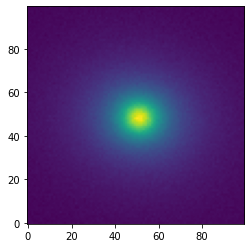

(array([48], dtype=int64), array([50], dtype=int64))
50.0 50.0


In [23]:
ncols,nrows = imageNp.shape
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')
  
plt.show()

inds = np.where(imageNp==imageNp.max())
print(inds)
print(ncols/2,nrows/2)

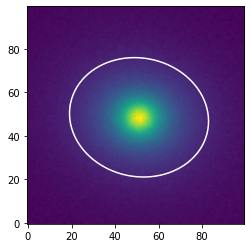

In [8]:
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')

j =(len(isolist)-1)
iso = isolist[j]
x, y, = iso.sampled_coordinates()
ax.plot(x, y, color='white')
plt.show()

C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Outer sersic:  0.35048054739724965 2.775022271178835
Outer sersic:  37.2859058106528 292.45580433703765
amplitude:  2529.9093434473416
Outer sersic:  2.461411172562755 4.593802390270924 104.43992633996875 43.55865815597177 44.78167550923157


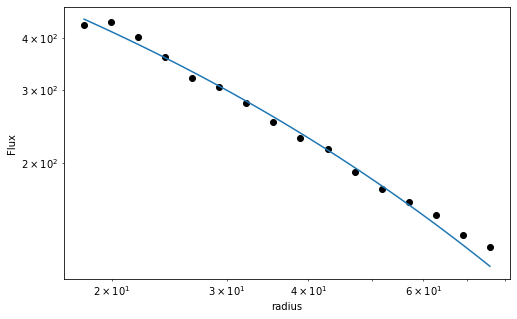

C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.17086923218487854 2.2165989854830883
7.607156127649651 780.9248265289933
amplitude:  2169.0072555591737
0.7049883511000514 1.09420008621467 Parameter('r_eff', value=7.229747278753613) 38.35725546956045 40.523476398570104


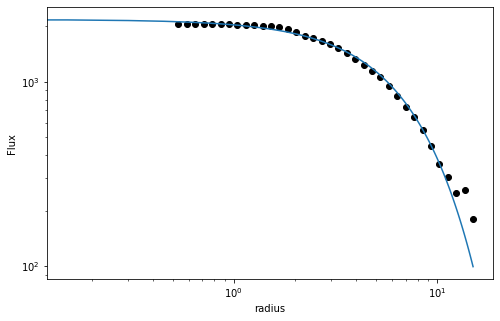

height:  13.39229267400361
number of faces: 45376
r_scale = Parameter('r_eff', value=7.229747278753613), n_inner = 0.7049883511000514 and n_outer = 2.461411172562755


In [24]:
#Code for 3D model of m64 with theoretical model attached

#Loading the file
directory = 'm_64_(spiral)'
F = fits.open(directory+'/200415_Li_.00000047.M_64.FIT')

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[850:996,1548:1700]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#reducing resolution of the image to the above parameters
resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()

#Outer sersic fit:
begin_edge = len(isolist1)-16
end_edge = len(isolist1)-0

isolist_edge= isolist1[begin_edge: end_edge]

el_edge = isolist_edge.eps.mean()# ellipticity (not eccentricity)
posa_edge = isolist_edge.pa.mean() #position angle

print("Outer sersic: ",el_edge,posa_edge)

spec_edge = isolist_edge.intens #intensity gradient
rs_edge = isolist_edge.sma #semi major axis
tfluxlist_edge = isolist_edge.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist_edge[i] < tfluxlist_edge[-1]/2:
    i += 1

r_scale1_edge = (tfluxlist_edge[i]-tfluxlist_edge[-1]/2)/(tfluxlist_edge[i]-tfluxlist_edge[i-1])*(rs_edge[i]-rs_edge[i-1])+rs_edge[i-1]
Amp_edge = (spec_edge[i-1]-spec_edge[i])*(r_scale1_edge-rs_edge[i-1])+ spec_edge[i-1]

print("Outer sersic: ",r_scale1_edge,Amp_edge)

#Fitting the physical model to the data
init_edge = models.Sersic1D(amplitude = Amp_edge, r_eff = r_scale1_edge,n=4)

fit_edge = fitting.LevMarLSQFitter()
t_edge = fit_edge(init_edge, rs_edge, spec_edge)

n_edge = t_edge.n[0]

r_scale_edge = t_edge.r_eff[0]*resfrac
r_scale_edge_2 = t_edge.r_eff[0]

#Finding (analytically) what the parameter b should be
b_edge = scop.minimize(b_optimizable, x0=2, args = n_edge ,bounds = [(0,None)], tol=1e-8).x[0]

x_off_edge = isolist_edge.y0.mean()*resfrac

y_off_edge = isolist_edge.x0.mean()*max_rows/nrows

Amp_edge = t_edge.amplitude[0]*np.exp(b_edge)

print("amplitude: ",Amp_edge)

print("Outer sersic: ",n_edge,b_edge,r_scale_edge,x_off_edge,y_off_edge)

#Plotting how well we fitted
X_edge = np.linspace(min(rs_edge),max(rs_edge),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs_edge, spec_edge, 'ko')
plt.plot(X_edge, t_edge(X_edge))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()

#Creating edge Sersic model
isolist= isolist1[0: begin_edge]

x_off = isolist.y0[5]*resfrac
x_off_2 = isolist.y0[5]

y_off = isolist.x0[5]*max_rows/nrows
y_off_2 = isolist.x0[5]

edge_modelarr = np.zeros((ncols,nrows))
#Only model on the outside
for x in range(0, ncols):
    for y in range(0, nrows):
        edge_modelarr[x][y] = Amp_edge*Sersic2D(x,y,x_off_2,y_off_2,n_edge,b_edge,r_scale_edge_2,el_edge,posa_edge)*(1-1/(1+np.sqrt((x-x_off_2)**2+(y-y_off_2)**2)**0.2))/(1-1/(1+np.sqrt((ncols-x_off_2-1)**2+(nrows-y_off_2-1)**2)**0.2))


geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp-edge_modelarr, geometry) 
isolist1 = ellipse.fit_image()

#Inner sersic fit:
begin = 0
end= len(isolist1)-9

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

n = t.n[0]

r_scale_2 = t.r_eff

#Finding (analytically) what the parameter b should be
b = scop.minimize(b_optimizable, x0=2, args = n ,bounds = [(0,None)], tol=1e-8).x[0]

x_off = isolist.y0[0]*resfrac
x_off_2 = isolist.y0[0]

y_off = isolist.x0[0]*max_rows/nrows
y_off_2 = isolist.x0[0]

Amp_in = t.amplitude[0]*np.exp(b)
print("amplitude: ",Amp_in)

print(n,b,r_scale_2,x_off,y_off)


#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()


#Making the physical model using fitted parameters        
modelarr_in_2 = np.zeros((ncols,nrows))
modelarr_edge_2 = np.zeros((ncols,nrows))
M_scale = []

for x in range(0, ncols):
    for y in range(0, nrows):
        xp = (x-x_off_2)*np.cos(-posa) + (y-y_off_2)*np.sin(-posa)
        yp = (y-y_off_2)*np.cos(-posa) - (x-x_off_2)*np.sin(-posa)
        modelarr_in_2[x][y] = Amp_in*Sersic2D(x,y,x_off_2,y_off_2,n,b,r_scale_2,el,posa)
        modelarr_edge_2[x][y] =4*Amp_edge*Sersic2D(x,y,x_off_2,y_off_2,n_edge,b_edge,r_scale_edge_2,el,posa)*(1-1/(1+np.sqrt((xp/(1-el))**2+yp**2)**0.2))      

xp = (ncols-x_off_2-1)*np.cos(-posa) + (nrows-y_off_2-1)*np.sin(-posa)
yp = (nrows-y_off_2-1)*np.cos(-posa) - (ncols-x_off_2-1)*np.sin(-posa)  

modelarr_2 = modelarr_edge_2/(1-1/(1+np.sqrt((xp/(1-el))**2+yp**2)**0.2)) + modelarr_in_2

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m_2=modelarr_2.min()
modelarr_2 -= min_pix_m_2
max_pix_m_2=modelarr_2.max()

min_pix_i_2=imageNp.min()
imageNp -= min_pix_i_2
max_pix_i_2=imageNp.max()

scaledmodelarr_2 = (modelarr_2 * max_height) / max_pix_m_2 + 1.6   #lowest vertex will be at 1.6 mm
scaledimageNp = (imageNp * max_height) / max_pix_i_2 + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model            
compNp_2 = np.zeros((ncols,nrows))
for x in range(0,ncols):
    for y in range(0,nrows):
        if x <= ncols/2:
            compNp_2[x][y] = scaledmodelarr_2[x][y]
        else:
            compNp_2[x][y] = scaledimageNp[x][y]

#Creating the list of faces out of the array                        
H1 = Sersic(r_scale_2,n,b,r_scale_2)     
height = H1*max_height
print("height: ", height)

elfaces_2 = ellipsemaker(max_cols,max_rows,x_off,y_off,r_scale_2, el, posa,height,1.5)
faces_2 = facemaker_v2(compNp_2,max_cols,max_rows)

print(f"number of faces: {len(faces_2)+len(elfaces_2)}")
facesNp_2 = np.append(faces_2,elfaces_2,axis = 0)

# Create the mesh
surface_2 = mesh.Mesh(np.zeros(facesNp_2.shape[0], dtype=mesh.Mesh.dtype))

for i in range(len(faces_2)+len(elfaces_2)):
    for j in range(3):
        surface_2.vectors[i][j] = facesNp_2[i][j]
        
# Write the mesh to a file so we can print it
surface_2.save('Sersic_model_+_spiral_M_64_v2.stl')

print("r_scale = {}, n_inner = {} and n_outer = {}".format(r_scale_2,n,n_edge))

F.close()

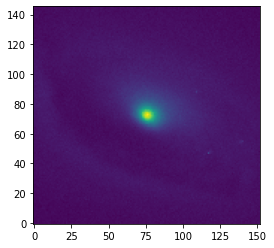

(array([73], dtype=int64), array([76], dtype=int64))
73.0 76.0


In [10]:
ncols,nrows = imageNp.shape
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')
  
plt.show()

inds = np.where(imageNp==imageNp.max())
print(inds)
print(ncols/2,nrows/2)

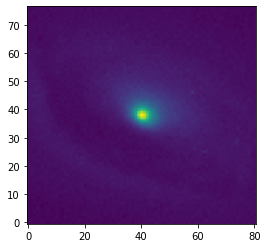

(array([38], dtype=int64), array([40], dtype=int64))
38.5 40.5
38.35725546956045 40.523476398570104


In [11]:
fig, ax = plt.subplots()
ax.imshow(resimNp, origin='lower')

plt.show()

inds = np.where(resimNp==resimNp.max())
print(inds)
print(max_cols/2,max_rows/2)
print(x_off,y_off)

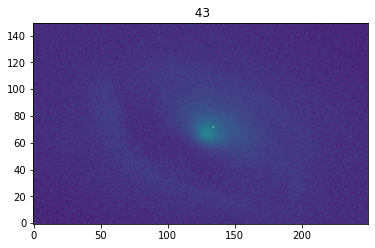

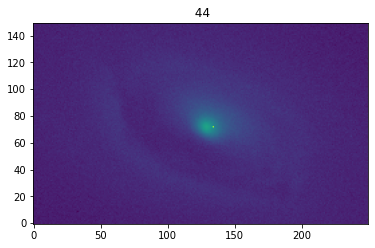

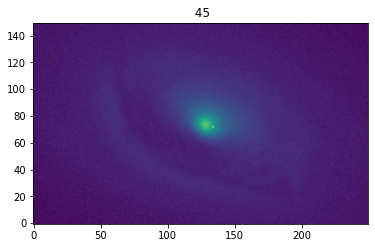

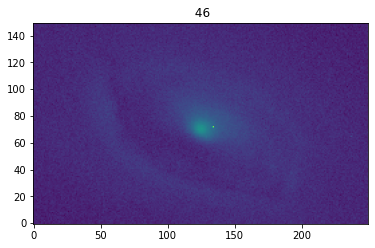

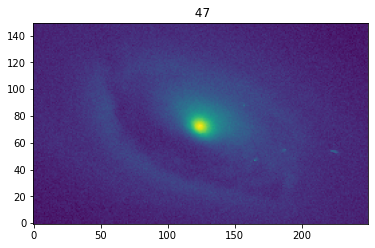

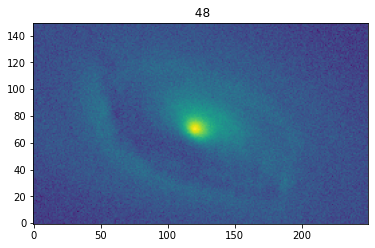

In [12]:
for i in range(6):
    directory = 'm_64_(spiral)'
    F = fits.open(directory+'/200415_Li_.000000{}.M_64.FIT'.format(43+i))
    
    originalimageNp = np.array(F[0].data)

    imageNp = np.nan_to_num(np.log10(originalimageNp[850:1000,1500:1750]))
    
    resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

    resimNp = resimNp -resimNp.min()
    
    fig, ax = plt.subplots()
    ax.imshow(imageNp, origin='lower')
    plt.title(' {}'.format(43+i))
    plt.show()

Outer sersic:  0.2690007807421074 2.107162936796162
Outer sersic:  74.89271702633391 3655.35478201926
amplitude:  6253.406594635101
Outer sersic:  1.753166323605321 3.1792259007501213 98.03067271162293 40.96285763993226 37.08242051691375


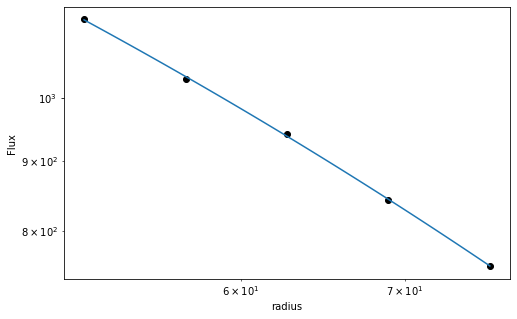

0.15673747736039587 2.5233578460437744
16.37500735955419 2674.2988525453866
amplitude:  10760.504708330242
0.8195234562116451 1.3204223492964915 Parameter('r_eff', value=13.14959593752485) 40.598209706462875 37.534635717497814


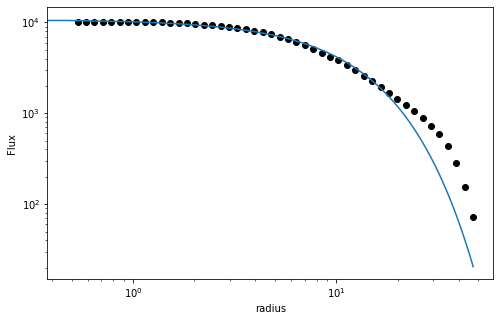

0.0007674998067908142 497.68339714336264
number of faces: 31612
r_scale = Parameter('r_eff', value=13.14959593752485), n_inner = 0.8195234562116451 and n_outer = 1.753166323605321


In [25]:
#TRY TO ZOOM OUT

#Code for 3D model of m81 with theoretical model attached

#Loading the file
directory = 'm_81_(spiral)'
F = fits.open(directory+'/200415_Li_.00000035.M_81.FIT')

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[1000:1128,1580:1700]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#reducing resolution of the image to the above parameters
resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()

#Outer sersic fit:
begin_edge = len(isolist1)-5

end_edge = len(isolist1)-0

isolist_edge= isolist1[begin_edge: end_edge]

el_edge = isolist_edge.eps.mean()# ellipticity (not eccentricity)
posa_edge = isolist_edge.pa.mean() #position angle

print("Outer sersic: ",el_edge,posa_edge)

spec_edge = isolist_edge.intens #intensity gradient
rs_edge = isolist_edge.sma #semi major axis
tfluxlist_edge = isolist_edge.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist_edge[i] < tfluxlist_edge[-1]/2:
    i += 1

r_scale1_edge = (tfluxlist_edge[i]-tfluxlist_edge[-1]/2)/(tfluxlist_edge[i]-tfluxlist_edge[i-1])*(rs_edge[i]-rs_edge[i-1])+rs_edge[i-1]
Amp_edge = (spec_edge[i-1]-spec_edge[i])*(r_scale1_edge-rs_edge[i-1])+ spec_edge[i-1]

print("Outer sersic: ",r_scale1_edge,Amp_edge)

#Fitting the physical model to the data
init_edge = models.Sersic1D(amplitude = Amp_edge, r_eff = r_scale1_edge,n=4)

fit_edge = fitting.LevMarLSQFitter()
t_edge = fit_edge(init_edge, rs_edge, spec_edge)

n_edge = t_edge.n[0]

r_scale_edge = t_edge.r_eff[0]*resfrac
r_scale_edge_2 = t_edge.r_eff[0]

#Finding (analytically) what the parameter b should be
b_edge = scop.minimize(b_optimizable, x0=2, args = n_edge ,bounds = [(0,None)], tol=1e-8).x[0]

x_off_edge = isolist_edge.y0.mean()*resfrac

y_off_edge = isolist_edge.x0.mean()*max_rows/nrows

Amp_edge = t_edge.amplitude[0]*np.exp(b_edge)

print("amplitude: ",Amp_edge)

print("Outer sersic: ",n_edge,b_edge,r_scale_edge,x_off_edge,y_off_edge)

#Plotting how well we fitted
X_edge = np.linspace(min(rs_edge),max(rs_edge),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs_edge, spec_edge, 'ko')
plt.plot(X_edge, t_edge(X_edge))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()


#Creating edge Sersic model
isolist= isolist1[0: begin_edge]

x_off = isolist.y0[5]*resfrac
x_off_2 = isolist.y0[5]

y_off = isolist.x0[5]*max_rows/nrows
y_off_2 = isolist.x0[5]

edge_modelarr = np.zeros((ncols,nrows))
#Only model on the outside
for x in range(0, ncols):
    for y in range(0, nrows):
        edge_modelarr[x][y] = Amp_edge*Sersic2D(x,y,x_off_2,y_off_2,n_edge,b_edge,r_scale_edge_2,el_edge,posa_edge)*(1-1/(1+np.sqrt((x-x_off_2)**2+(y-y_off_2)**2)**0.2))/(1-1/(1+np.sqrt((ncols-x_off_2-1)**2+(nrows-y_off_2-1)**2)**0.2))


geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.1, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp-edge_modelarr, geometry) 
isolist1 = ellipse.fit_image()

#Inner sersic fit:
begin = 0
end= len(isolist1)-4

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

n = t.n[0]

r_scale_2 = t.r_eff

#Finding (analytically) what the parameter b should be
b = scop.minimize(b_optimizable, x0=2, args = n ,bounds = [(0,None)], tol=1e-8).x[0]

x_off = isolist.y0[0]*resfrac
x_off_2 = isolist.y0[0]

y_off = isolist.x0[0]*max_rows/nrows
y_off_2 = isolist.x0[0]

Amp_in = t.amplitude[0]*np.exp(b)
print("amplitude: ",Amp_in)

print(n,b,r_scale_2,x_off,y_off)


#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()


#Making the physical model using fitted parameters
modelarr_in_2 = np.zeros((ncols,nrows))
modelarr_edge_2 = np.zeros((ncols,nrows))
for x in range(0, ncols):
    for y in range(0, nrows):
        modelarr_in_2[x][y] = Amp_in*Sersic2D(x,y,x_off_2,y_off_2,n,b,r_scale_2,el,posa)
        modelarr_edge_2[x][y] =Amp_edge*Sersic2D(x,y,x_off_2,y_off_2,n_edge,b_edge,r_scale_edge_2,el,posa)*(1-1/(1+np.sqrt((x-x_off_2)**2+(y-y_off_2)**2)**0.2))/(1-1/(1+np.sqrt((ncols-x_off_2-1)**2+(nrows-y_off_2-1)**2)**0.2))      

print(modelarr_in_2[0][0],modelarr_edge_2[0][0])
modelarr_2 = modelarr_edge_2  +modelarr_in_2

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m_2=modelarr_2.min()
modelarr_2 -= min_pix_m_2
max_pix_m_2=modelarr_2.max()

min_pix_i_2=imageNp.min()
imageNp -= min_pix_i_2
max_pix_i_2=imageNp.max()

scaledmodelarr_2 = (modelarr_2 * max_height) / max_pix_m_2 + 1.6   #lowest vertex will be at 1.6 mm
scaledimageNp = (imageNp * max_height) / max_pix_i_2 + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model           
compNp_2 = np.zeros((ncols,nrows))
for x in range(0,ncols):
    for y in range(0,nrows):
        if x <= ncols/2:
            compNp_2[x][y] = scaledmodelarr_2[x][y]
        else:
            compNp_2[x][y] = scaledimageNp[x][y]

#Creating the list of faces out of the array                        
H1 = Sersic(r_scale_2,n,b,r_scale_2)     
height = H1*max_height

faces_2 = facemaker_v2(compNp_2,max_cols,max_rows)
elfaces_2 = ellipsemaker(max_cols,max_rows,x_off,y_off,r_scale_2, el, posa,height,2)

print(f"number of faces: {len(faces_2)+len(elfaces_2)}")
facesNp_2 =np.append(faces_2,elfaces_2,axis = 0) 

surface_2 = mesh.Mesh(np.zeros(facesNp_2.shape[0], dtype=mesh.Mesh.dtype))

# Create the mesh
for i in range(len(faces_2)+len(elfaces_2)):
    for j in range(3):
        surface_2.vectors[i][j] = facesNp_2[i][j]
        
# Write the mesh to a file so we can print it
surface_2.save('Sersic_model_+_spiral_M_81_v2.stl')

print("r_scale = {}, n_inner = {} and n_outer = {}".format(r_scale_2,n,n_edge))

F.close()

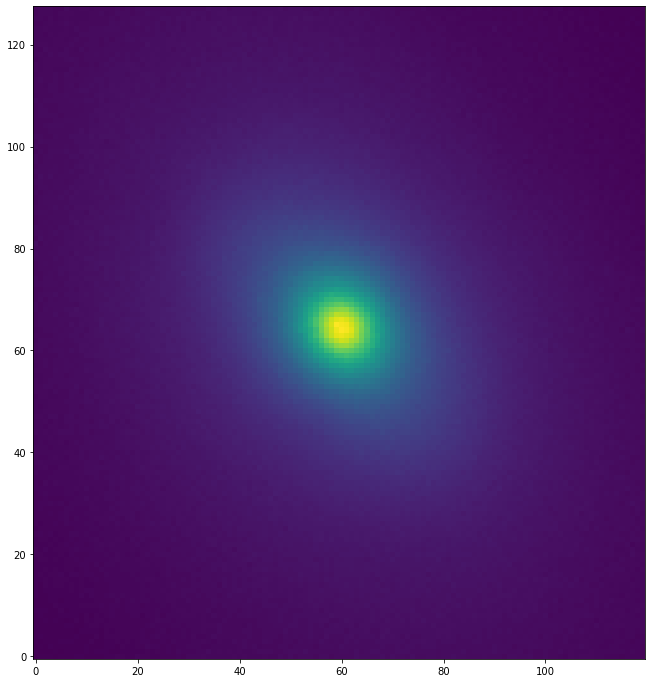

(array([64], dtype=int64), array([60], dtype=int64))
64.0 60.0
40.598209706462875 37.534635717497814


In [26]:
ncols,nrows = imageNp.shape

plt.figure(figsize=(12,12))
plt.subplot(111)
A = plt.imshow(imageNp, origin='lower')
#plt.colorbar(A)
#plt.xlabel('x pixel')
#plt.ylabel('y pixel')
plt.show()

inds = np.where(imageNp==imageNp.max())
print(inds)
print(ncols/2,nrows/2)
print(x_off,y_off)

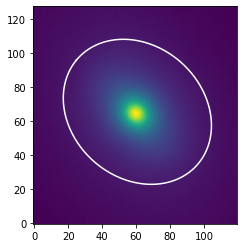

(array([41], dtype=int64), array([37], dtype=int64))
40.5 37.5
60.21233864285134 64.52293177447062


In [15]:
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')

iso_b = isolist1[begin]
iso_e = isolist1[end-1]

x_b, y_b, = iso_b.sampled_coordinates()
ax.plot(x_b, y_b, color='white')
x_e, y_e, = iso_e.sampled_coordinates()
ax.plot(x_e, y_e, color='white')
plt.show()

inds = np.where(resimNp==resimNp.max())
print(inds)
print(max_cols/2,max_rows/2)
print(isolist.x0.mean(),isolist.y0.mean())

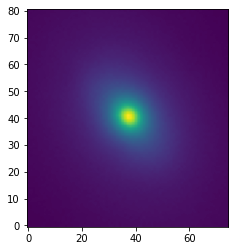

(array([41], dtype=int64), array([37], dtype=int64))
40.5 37.5
40.598209706462875 37.534635717497814


In [16]:
fig, ax = plt.subplots()
ax.imshow(resimNp, origin='lower')

plt.show()

inds = np.where(resimNp==resimNp.max())
print(inds)
print(max_cols/2,max_rows/2)
print(x_off,y_off)

0.6552665178727362 2.0367590449427584
35.35191930223843 383.4902928725425


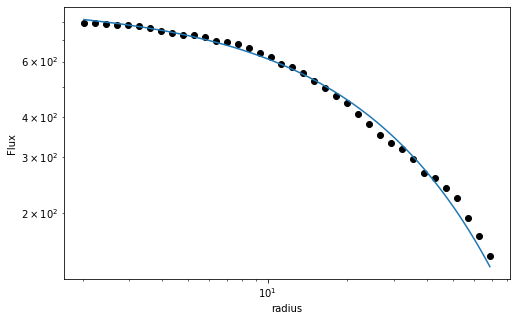

1.2229635146988287 2.121883183469244 78.89071612052813 44.392121007320895 47.571448689085685
number of faces 2: 18440


In [28]:
'''
#Code for 3D model of NGC 5907 with theoretical model attached

#Loading the file
directory = 'NGC_5907_(spiral)'
F = fits.open(directory+'/200422_Li_.00000070.NGC_5907.FIT')

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[1048:1138,1427:1527]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#reducing resolution of the image to the above parameters
resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.65, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()

begin = 15
end = len(isolist1)-0

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()

n = t.n[0]

r_scale = t.r_eff[0]*resfrac

#Finding (analytically) what the parameter b should be
b = scop.minimize(b_optimizable, x0=2, args = n ,bounds = [(0,None)], tol=1e-8).x[0]


x_off = isolist.y0[0]*resfrac

y_off = isolist.x0[0]*max_rows/nrows

print(n,b,r_scale,x_off,y_off)

#Making the physical model using fitted parameters
modelarr = np.zeros((max_cols,max_rows))
for x in range(0, max_cols):
    for y in range(0, max_rows):
        modelarr[x][y] = Sersic2D(x,y,x_off,y_off,n,b,r_scale,el,posa)

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m=modelarr.min()
modelarr -= min_pix_m
max_pix_m=modelarr.max()

min_pix_i=resimNp.min()
resimNp -= min_pix_i
max_pix_i=resimNp.max()

scaledmodelarr = (modelarr * max_height) / max_pix_m + 1.6   #lowest vertex will be at 1.6 mm
scaledresimNp = (resimNp * max_height) / max_pix_i + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model
compNp = np.zeros((max_cols,max_rows))
for x in range(0,max_cols):
    for y in range(0,max_rows):
        if x <= max_cols/2:
            compNp[x][y] = scaledmodelarr[x][y]
        else:
            compNp[x][y] = scaledresimNp[x][y]

#Creating the list of faces out of the array                        
faces = facemaker(compNp,max_cols,max_rows,x_off,y_off) #,r_scale,el,posa)
elfaces = ellipsemaker(max_cols,max_rows,x_off,y_off,r_scale, el, posa,Sersic(r_scale,n,b,r_scale)*max_height+1.6,6)
#elfaces = []

print(f"number of faces: {len(faces)+len(elfaces)}")
facesNp = np.append(faces,elfaces,axis = 0) 
#facesNp = np.array(faces)

# Create the mesh
surface = mesh.Mesh(np.zeros(facesNp.shape[0], dtype=mesh.Mesh.dtype))
for i in range(len(faces)+len(elfaces)):
    for j in range(3):
        surface.vectors[i][j] = facesNp[i][j]
        
# Write the mesh to a file so we can print it
surface.save('Sersic_model_+_spiral_NGC_5907.stl')

F.close()
'''





















#Code for 3D model of m87 with theoretical model attached

#Loading the file
directory = 'NGC_5907_(spiral)'
F = fits.open(directory+'/200422_Li_.00000070.NGC_5907.FIT')

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[1048:1138,1427:1527]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#reducing resolution of the image to the above parameters
resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=15, eps=0.65, pa=115.*np.pi/180.)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()

begin = 15
end = len(isolist1)-0

isolist= isolist1[begin: end]

el = isolist.eps[10:].mean()# ellipticity (not eccentricity)
posa = isolist.pa[10:].mean() #position angle

print(el,posa)

spec = isolist.intens #intensity gradient
rs = isolist.sma #semi major axis
tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Getting the scaling radius (radius at which we have half of the total intensity of galaxy)
i = 1
while tfluxlist[i] < tfluxlist[-1]/2:
    i += 1

r_scale1 = (tfluxlist[i]-tfluxlist[-1]/2)/(tfluxlist[i]-tfluxlist[i-1])*(rs[i]-rs[i-1])+rs[i-1]
Amp = (spec[i-1]-spec[i])*(r_scale1-rs[i-1])+ spec[i-1]

print(r_scale1,Amp)

#Fitting the physical model to the data
init = models.Sersic1D(amplitude = Amp, r_eff = r_scale1,n=1)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()

n = t.n[0]

r_scale_2 = t.r_eff[0]

#Finding (analytically) what the parameter b should be
b = scop.minimize(b_optimizable, x0=2, args = n ,bounds = [(0,None)], tol=1e-8).x[0]

x_off_2 = isolist.y0[10:-1].mean()

y_off_2 = isolist.x0[10:-1].mean()

print(n,b,r_scale_2,x_off_2,y_off_2)

#Making the physical model using fitted parameters
modelarr_2 = np.zeros((ncols,nrows))

for x in range(0,ncols):
    for y in range(0, nrows):
        modelarr_2[x][y] = Sersic2D(x,y,x_off_2,y_off_2,n,b,r_scale_2,el,posa)

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m_2=modelarr_2.min()
modelarr_2 -= min_pix_m_2
max_pix_m_2=modelarr_2.max()

min_pix_i_2=imageNp.min()
imageNp -= min_pix_i_2
max_pix_i_2=imageNp.max()

scaledmodelarr_2 = (modelarr_2 * max_height) / max_pix_m_2 + 1.6   #lowest vertex will be at 1.6 mm
scaledimageNp = (imageNp * max_height) / max_pix_i_2 + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model         
compNp_2 = np.zeros((ncols,nrows))
for x in range(0,ncols):
    for y in range(0,nrows):
        if x <= ncols/2:
            compNp_2[x][y] = scaledmodelarr_2[x][y]
        else:
            compNp_2[x][y] = scaledimageNp[x][y]

#Creating the list of faces out of the array                        
faces_2 = facemaker_v2(compNp_2,max_cols,max_rows)
elfaces_2 = ellipsemaker(max_cols,max_rows,x_off_2*resfrac,y_off_2*max_rows/nrows,r_scale_2*resfrac, el, posa,Sersic(r_scale_2*resfrac,n,b,r_scale_2*resfrac)*max_height+1.6,10)
#elfaces = []

print(f"number of faces 2: {len(faces_2)+len(elfaces_2)}") 
facesNp_2 = np.append(faces_2,elfaces_2,axis = 0) 
#facesNp = np.array(faces)

# Create the mesh       
surface_2 = mesh.Mesh(np.zeros(facesNp_2.shape[0], dtype=mesh.Mesh.dtype))
for i in range(len(faces_2)+len(elfaces_2)):
    for j in range(3):
        surface_2.vectors[i][j] = facesNp_2[i][j]
        
# Write the mesh to a file so we can print it
surface_2.save('Sersic_model_+_spiral_NGC_5907_v2.stl')

F.close()

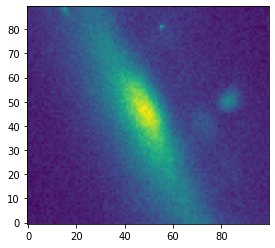

(array([45], dtype=int64), array([50], dtype=int64))
45.0 50.0


In [18]:
ncols,nrows = imageNp.shape
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')
  
plt.show()

inds = np.where(imageNp==imageNp.max())
print(inds)
print(ncols/2,nrows/2)

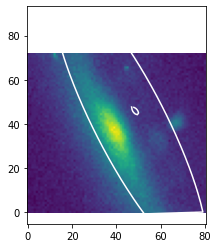

(array([38], dtype=int64), array([39], dtype=int64))
36.0 40.5
47.7882690231261 44.68297429170461
0.6552665178727362 0.7650434650263435
2.0367590449427584 2.0444750342823297


In [19]:
fig, ax = plt.subplots()
ax.imshow(resimNp, origin='lower')

iso_b = isolist1[begin]
iso_e = isolist1[end-1]

x_b, y_b, = iso_b.sampled_coordinates()
ax.plot(x_b, y_b, color='white')
x_e, y_e, = iso_e.sampled_coordinates()
ax.plot(x_e, y_e, color='white')
plt.show()

inds = np.where(resimNp==resimNp.max())
print(inds)
print(max_cols/2,max_rows/2)
print(isolist.x0.mean(),isolist.y0.mean())
print(el,iso_e.eps)
print(posa,iso_e.pa)

0.1325786863223703 0.8548084266048781


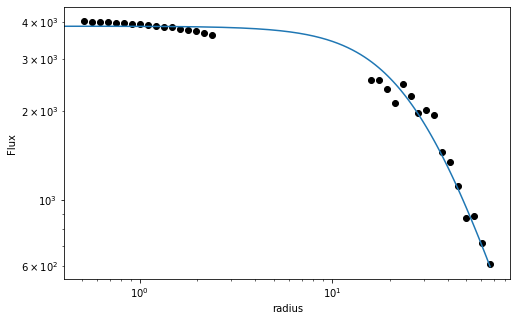

3.8364705788858102 209299216.69527677 40.16194718369696 38.51411087529197
FOV:  0.27480496665056137
number of faces: 13842


In [33]:
#Code for 3D model of m53 with theoretical model attached

#Loading the file
directory = 'm_53_(globlular)'
F = fits.open(directory+'/200420_Li_.00000096.M_53.FIT')

originalimageNp = np.array(F[0].data)

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[750:1350,1300:1900]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#reducing resolution of the image to the above parameters
resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2-15, y0=nrows/2, sma=50, eps=0.1, pa=0.5)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()


isolist = np.append(isolist1[0:18],isolist1[37:],axis = 0) 

el = isolist[-1].eps# ellipticity (not eccentricity)
posa = isolist[-1].pa #position angle

print(el,posa)

spec = [iso.intens for iso in isolist] #intensity gradient
rs = [iso.sma for iso in isolist] #semi major axis
#tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Fitting the physical model to the data
init = models.KingProjectedAnalytic1D(amplitude = 1000, r_core = 4, r_tide = 1000)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()

r_t = t.r_tide[0]*resfrac

r_c = t.r_core[0]*resfrac

x_off = isolist[-1].y0*resfrac

y_off = isolist[-1].x0*max_rows/nrows

print(r_c,r_t,x_off,y_off)

print("FOV: ",r_c/resfrac*0.00967)

#Making the physical model using fitted parameters
modelarr = np.zeros((max_cols,max_rows))
for x in range(0, max_cols):
    for y in range(0, max_rows):
        modelarr[x][y] = King2D(x,y,x_off,y_off,r_c,r_t,el,posa)

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m=modelarr.min()
modelarr -= min_pix_m
max_pix_m=modelarr.max()

min_pix_i=resimNp.min()
resimNp -= min_pix_i
max_pix_i=resimNp.max()

scaledmodelarr = (modelarr * max_height) / max_pix_m + 1.6   #lowest vertex will be at 1.6 mm
scaledresimNp = (resimNp * max_height) / max_pix_i + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model
compNp = np.zeros((max_cols,max_rows))
for x in range(0,max_cols):
    for y in range(0,max_rows):
        if x <= max_cols/2:
            compNp[x][y] = scaledmodelarr[x][y]
        else:
            compNp[x][y] = scaledresimNp[x][y]

#Creating the list of faces out of the array                        
faces = facemaker(compNp,max_cols,max_rows,x_off,y_off)
elfaces = ellipsemaker(max_cols,max_rows,x_off,y_off,r_c, el, posa,King1D(r_c,r_c,r_t,el,posa)*max_height+1.6,1)

print(f"number of faces: {len(faces)+len(elfaces)}")
facesNp = np.append(faces,elfaces,axis = 0) 


# Create the mesh
surface = mesh.Mesh(np.zeros(facesNp.shape[0], dtype=mesh.Mesh.dtype))
for i in range(len(faces)+len(elfaces)):
    for j in range(3):
        surface.vectors[i][j] = facesNp[i][j]
        
# Write the mesh to a file so we can print it
surface.save('King_model_+_globular_M_53.stl')

F.close()

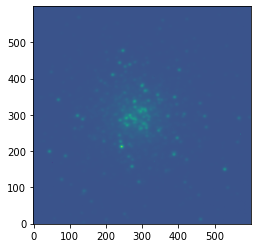

(array([247], dtype=int64), array([571], dtype=int64))
300.0 300.0


In [34]:
ncols,nrows = imageNp.shape
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')
geometry = EllipseGeometry(x0=ncols/2-15, y0=nrows/2, sma=50, eps=0.1, pa=0.5)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,geometry.sma*(1 - geometry.eps),geometry.pa)
#aper.plot(color='white')

plt.show()

inds = np.where(imageNp==imageNp.max())
print(inds)
print(ncols/2,nrows/2)

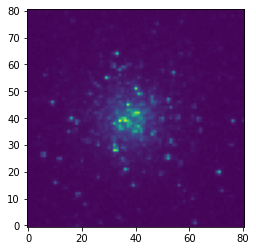

In [22]:
for i in range(len(isolist1)-1):
    
    i = i + 1
    #print(isolist.eps[i])
    geometry = EllipseGeometry(x0=isolist1.x0[i], y0=isolist1.y0[i], sma=isolist1.sma[i], eps=isolist1.eps[i], pa=isolist1.pa[i])
    aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,geometry.sma*(1 - geometry.eps),geometry.pa)
    plt.imshow(resimNp, origin='lower')
    aper.plot(color='white')

0.2575187165830538 2.1936687637816643


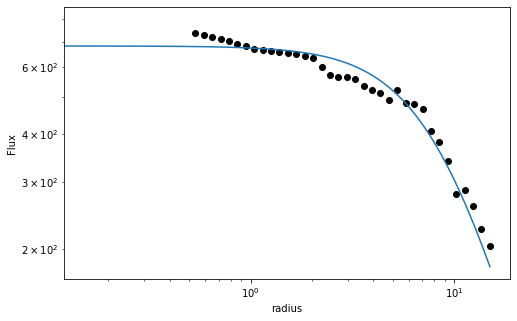

2.917796152075659 84463247.40509315 39.64797279775233 42.261912875194156
FOV:  0.08708360737830748
number of faces: 13842


In [3]:
#Code for 3D model of NGC 4147 with theoretical model attached

#Loading the file
directory = 'NGC_4147_(globlular)'
F = fits.open(directory+'/200420_Li_.00000030.NGC_4147.FIT')

originalimageNp = np.array(F[0].data)

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[925:1175,1525:1775]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#reducing resolution of the image to the above parameters
resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2+5, y0=nrows/2-5, sma=20, eps=0, pa=2)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()


isolist = np.append(isolist1[0:18],isolist1[18:-5],axis = 0) 

el = isolist[-1].eps# ellipticity (not eccentricity)
posa = isolist[-1].pa #position angle

print(el,posa)

spec = [iso.intens for iso in isolist] #intensity gradient
rs = [iso.sma for iso in isolist] #semi major axis
#tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Fitting the physical model to the data
init = models.KingProjectedAnalytic1D(amplitude = 600, r_core = 13, r_tide = 1000)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()

r_t = t.r_tide[0]*resfrac

r_c = t.r_core[0]*resfrac

x_off = isolist[-1].y0*resfrac

y_off = isolist[-1].x0*max_rows/nrows

print(r_c,r_t,x_off,y_off)

print("FOV: ",r_c/resfrac*0.00967)

#Making the physical model using fitted parameters
modelarr = np.zeros((max_cols,max_rows))
for x in range(0, max_cols):
    for y in range(0, max_rows):
        modelarr[x][y] = King2D(x,y,x_off,y_off,r_c,r_t,el,posa)

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m=modelarr.min()
modelarr -= min_pix_m
max_pix_m=modelarr.max()

min_pix_i=resimNp.min()
resimNp -= min_pix_i
max_pix_i=resimNp.max()

scaledmodelarr = (modelarr * max_height) / max_pix_m + 1.6   #lowest vertex will be at 1.6 mm
scaledresimNp = (resimNp * max_height) / max_pix_i + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model
compNp = np.zeros((max_cols,max_rows))
for x in range(0,max_cols):
    for y in range(0,max_rows):
        if x <= max_cols/2:
            compNp[x][y] = scaledmodelarr[x][y]
        else:
            compNp[x][y] = scaledresimNp[x][y]

#Creating the list of faces out of the array                        
faces = facemaker(compNp,max_cols,max_rows,x_off,y_off)
elfaces = ellipsemaker(max_cols,max_rows,x_off,y_off,r_c, el, posa,King1D(r_c,r_c,r_t,el,posa)*max_height+1.6,1)

print(f"number of faces: {len(faces)+len(elfaces)}")
facesNp = np.append(faces,elfaces,axis = 0) 


# Create the mesh
surface = mesh.Mesh(np.zeros(facesNp.shape[0], dtype=mesh.Mesh.dtype))
for i in range(len(faces)+len(elfaces)):
    for j in range(3):
        surface.vectors[i][j] = facesNp[i][j]
        
# Write the mesh to a file so we can print it
surface.save('King_model_+_globular_NGC_4147.stl')

F.close()

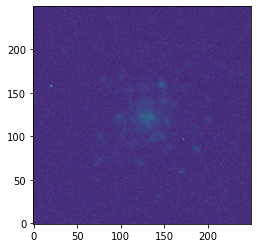

(array([97], dtype=int64), array([172], dtype=int64))
125.0 125.0


In [4]:
ncols,nrows = imageNp.shape
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,geometry.sma*(1 - geometry.eps),geometry.pa)
#aper.plot(color='white')

plt.show()

inds = np.where(imageNp==imageNp.max())
print(inds)
print(ncols/2,nrows/2)

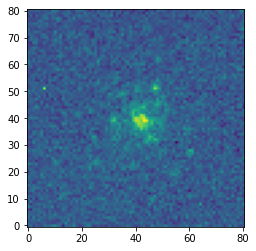

In [26]:
for i in range(len(isolist1)-1):
    
    i = i + 1
    #print(isolist.eps[i])
    geometry = EllipseGeometry(x0=isolist1.x0[i], y0=isolist1.y0[i], sma=isolist1.sma[i], eps=isolist1.eps[i], pa=isolist1.pa[i])
    aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,geometry.sma*(1 - geometry.eps),geometry.pa)
    plt.imshow(resimNp, origin='lower')
    aper.plot(color='white')

C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\jaspe\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.1 0.800958781011842


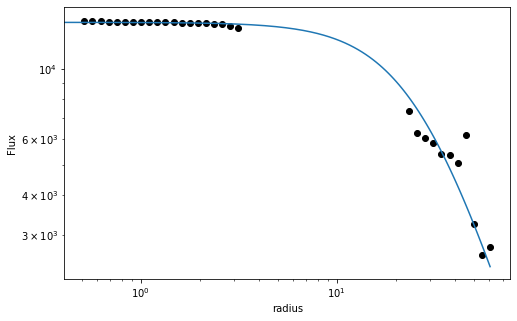

3.70912096672079 247488974.74252763 39.776019545395314 41.3060853805002
FOV:  0.26568296109770395
number of faces: 13842


In [30]:
#Code for 3D model of m53 with theoretical model attached

#Loading the file
directory = 'm_3_(globular)'
F = fits.open(directory+'/200420_Li_.00000109.M_3.FIT'.format(107+i))

originalimageNp = np.array(F[0].data)

originalimageNp = np.array(F[0].data)
background = (originalimageNp[0:15,0:15] + originalimageNp[0:15,-15] + originalimageNp[-15:,0:15] + originalimageNp[-15:,-15:] )/4
redoriginalimageNp = originalimageNp - background.mean()

imageNp = redoriginalimageNp[700:1300,1350:1950]

ncols,nrows = imageNp.shape

if ncols >= nrows:
    max_cols = 81
    max_rows = int(nrows/ncols*max_cols)
else:
    max_rows = 81
    max_cols = int(ncols/nrows*max_rows)
    
resfrac = max_cols/ncols

#reducing resolution of the image to the above parameters
resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

#Fitting ellipses to figure out the orientation of the galaxy
geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=50, eps=0.1, pa=0.5)

ellipse = Ellipse(imageNp, geometry) 
isolist1 = ellipse.fit_image()


isolist = np.append(isolist1[0:21],isolist1[41:],axis = 0) 

el = isolist[-1].eps# ellipticity (not eccentricity)
posa = isolist[-1].pa #position angle

print(el,posa)

spec = [iso.intens for iso in isolist] #intensity gradient
rs = [iso.sma for iso in isolist] #semi major axis
#tfluxlist = isolist.tflux_e #Intensity inside ellipse

#Fitting the physical model to the data
init = models.KingProjectedAnalytic1D(amplitude = 1000, r_core = 4, r_tide = 1000)

fit = fitting.LevMarLSQFitter()
t = fit(init, rs, spec)

#Plotting how well we fitted
X = np.linspace(min(rs),max(rs),100)
plt.figure(figsize=(8,5))
plt.subplot(111, xscale='log', yscale='log')
plt.plot(rs, spec, 'ko')
plt.plot(X, t(X))
plt.xlabel('radius')
plt.ylabel('Flux')
plt.show()

r_t = t.r_tide[0]*resfrac

r_c = t.r_core[0]*resfrac

x_off = isolist[-1].y0*resfrac

y_off = isolist[-1].x0*max_rows/nrows

print(r_c,r_t,x_off,y_off)

print("FOV: ",r_c/resfrac*0.00967)

#Making the physical model using fitted parameters
modelarr = np.zeros((max_cols,max_rows))
for x in range(0, max_cols):
    for y in range(0, max_rows):
        modelarr[x][y] = King2D(x,y,x_off,y_off,r_c,r_t,el,posa)

#Maximum (and minimum) height of the 3D model
max_height=40 #mm
min_height=0

#Scaling the data and physical model to real sizes (in mm)
min_pix_m=modelarr.min()
modelarr -= min_pix_m
max_pix_m=modelarr.max()

min_pix_i=resimNp.min()
resimNp -= min_pix_i
max_pix_i=resimNp.max()

scaledmodelarr = (modelarr * max_height) / max_pix_m + 1.6   #lowest vertex will be at 1.6 mm
scaledresimNp = (resimNp * max_height) / max_pix_i + 1.6     #lowest vertex will be at 1.6 mm

#Making the composite array of real data and physical model
compNp = np.zeros((max_cols,max_rows))
for x in range(0,max_cols):
    for y in range(0,max_rows):
        if x <= max_cols/2:
            compNp[x][y] = scaledmodelarr[x][y]
        else:
            compNp[x][y] = scaledresimNp[x][y]

#Creating the list of faces out of the array                        
faces = facemaker(compNp,max_cols,max_rows,x_off,y_off)
elfaces = ellipsemaker(max_cols,max_rows,x_off,y_off,r_c, el, posa,King1D(r_c,r_c,r_t,el,posa)*max_height+1.6,1)

print(f"number of faces: {len(faces)+len(elfaces)}")
facesNp = np.append(faces,elfaces,axis = 0) 


# Create the mesh
surface = mesh.Mesh(np.zeros(facesNp.shape[0], dtype=mesh.Mesh.dtype))
for i in range(len(faces)+len(elfaces)):
    for j in range(3):
        surface.vectors[i][j] = facesNp[i][j]
        
# Write the mesh to a file so we can print it
surface.save('King_model_+_globular_M_3.stl')

F.close()

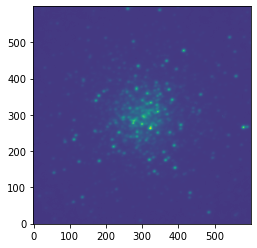

(array([263], dtype=int64), array([323], dtype=int64))
300.0 300.0


In [32]:
ncols,nrows = imageNp.shape
fig, ax = plt.subplots()
ax.imshow(imageNp, origin='lower')
#geometry = EllipseGeometry(x0=ncols/2, y0=nrows/2, sma=50, eps=0.1, pa=0.5)
#aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,geometry.sma*(1 - geometry.eps),geometry.pa)
#aper.plot(color='white')

plt.show()

inds = np.where(imageNp==imageNp.max())
print(inds)
print(ncols/2,nrows/2)

In [ ]:
for i in range(len(isolist1)-1):
    
    i = i + 1
    #print(isolist.eps[i])
    geometry = EllipseGeometry(x0=isolist1.x0[i], y0=isolist1.y0[i], sma=isolist1.sma[i], eps=isolist1.eps[i], pa=isolist1.pa[i])
    aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,geometry.sma*(1 - geometry.eps),geometry.pa)
    plt.imshow(resimNp, origin='lower')
    aper.plot(color='white')

IndexError: list index out of range

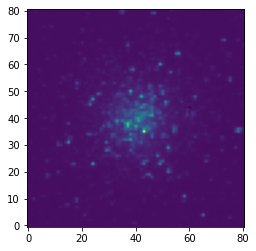

In [31]:
fig, ax = plt.subplots()
ax.imshow(resimNp, origin='lower')

iso_b = isolist1[begin]
iso_e = isolist1[end-1]

x_b, y_b, = iso_b.sampled_coordinates()
ax.plot(x_b, y_b, color='white')
x_e, y_e, = iso_e.sampled_coordinates()
ax.plot(x_e, y_e, color='white')
plt.show()

inds = np.where(resimNp==resimNp.max())
print(inds)
print(max_cols/2,max_rows/2)
print(isolist.x0.mean(),isolist.y0.mean())
print(el,iso_e.eps)
print(posa,iso_e.pa)

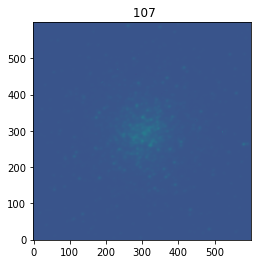

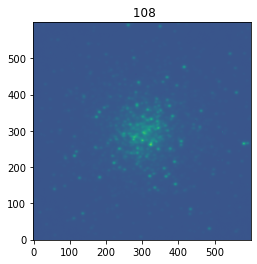

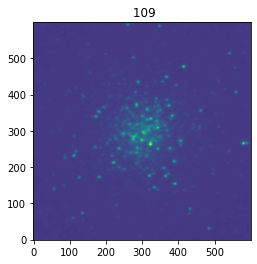

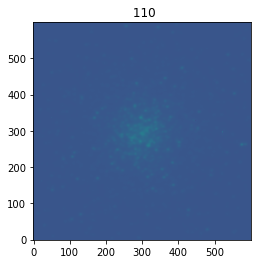

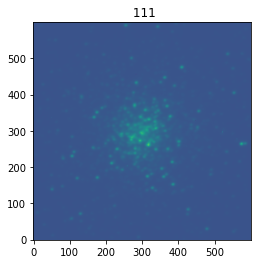

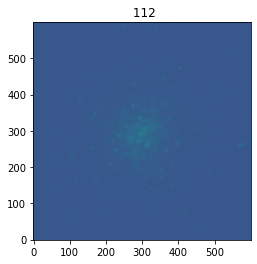

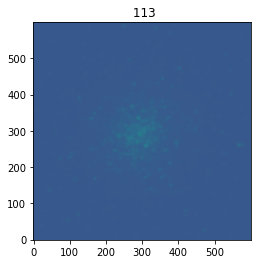

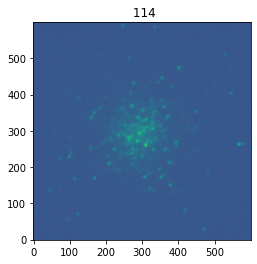

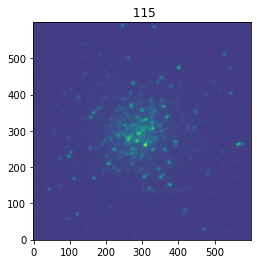

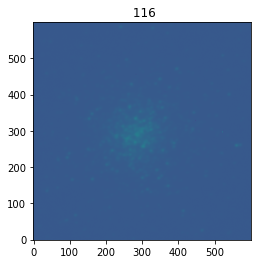

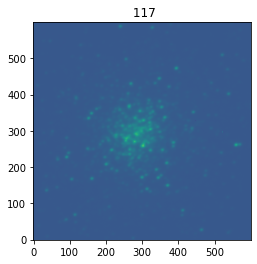

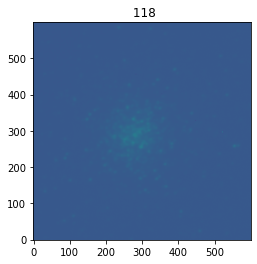

In [30]:
for i in range(12):
    directory = 'm_3_(globular)'
    F = fits.open(directory+'/200420_Li_.00000{}.M_3.FIT'.format(107+i))
    
    originalimageNp = np.array(F[0].data)
    
    resimNp = cv2.resize(imageNp, dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

    resimNp = resimNp -resimNp.min()
    
    fig, ax = plt.subplots()
    ax.imshow(originalimageNp[700:1300,1350:1950], origin='lower')
    plt.title(' {}'.format(107+i))
    plt.show()

In [ ]:
directory = 'NGC_5053_(globular)'
F = fits.open(directory+'/200420_Li_.00000061.NGC_5053.FIT')
    
originalimageNp = np.array(F[0].data)

imageNp = np.log10(originalimageNp[500:1500,850:2150])
    
resimNp = cv2.resize(np.nan_to_num(imageNp), dsize=(max_rows, max_cols), interpolation=cv2.INTER_CUBIC)

resimNp = resimNp -resimNp.min()
    
fig, ax = plt.subplots()
ax.imshow(resimNp, origin='lower')
  
plt.show()